# Approximation of Series with Markov-Chains

We compare the Tauchen (1986) and Rouwenhorst (1995) approximation method for discretesized Markow-Chain-Processes. We generate simulations based on the results of the two approximation methods and inspect them visually, as well as statistically. For the purpose at hand, we compute the mean, the standard deviation, as well as the first order autocorrelation, which gives us an estimation of the autoregressive coefficient. To support the visual inspection we conduct a MSE-analysis, as well. To compare the results of the approximations with the correct theoretical moments, we generate a first order autoregressive process of the following form:

$$y_t = \rho y_{t-1} + \epsilon_t$$

With $\epsilon \sim N(0, 0.02)$, and $\rho = 0.91$. We simulate all series for 10.000 periods and later compare the inputs for the simulation with estimations for the above indicated moments. As part of the exercise we define the scaling parameter for the Tauchen approximation to be 3, and generate the approximations with 5, 9 and 15 grid points.

To start with, we import the necessary packages:

In [1]:
import scipy.stats as st
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

With the environement set, we can start by defining the relevant parameters for the simulation, as well as simulating the data using a simple for loop. 

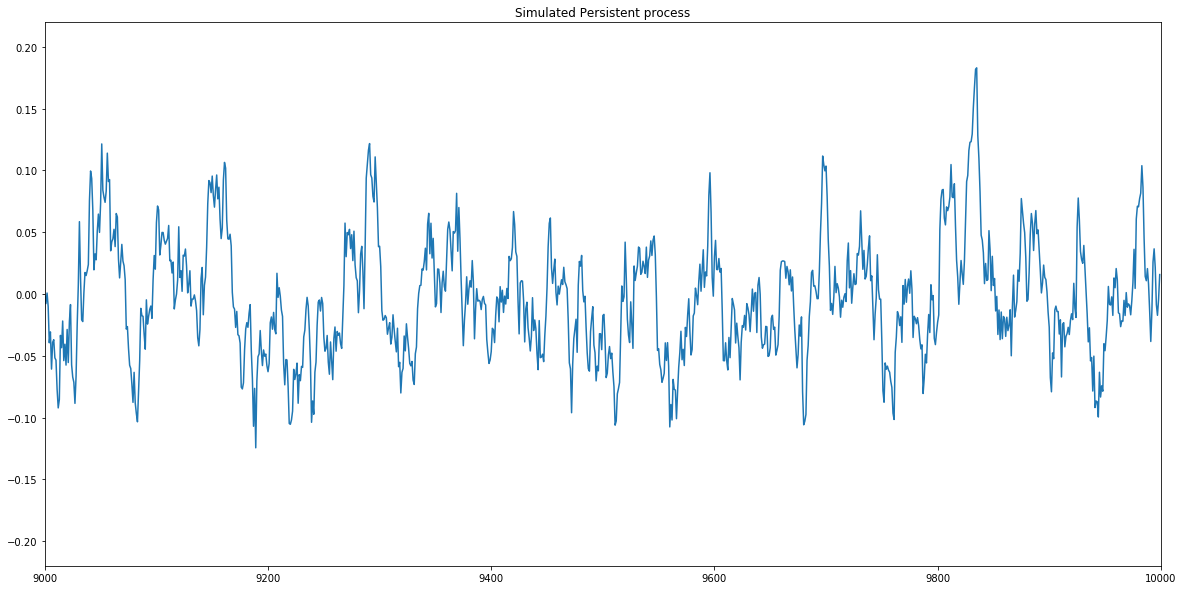

In [2]:
'Setting up the initial parameters'
np.random.seed(123)
rho1    = 0.91
mu      = 0
sigmae1 = 0.02
sigmay1 = (sigmae1**2 / (1 - rho1**2))**(1/2)
N1      = 5
m       = 3
start   = 3
N_sim   = 10000


'Simulate an AR(1) process which we will use later for comparison'
eps = np.random.normal(mu, sigmae1, N_sim)
sim = np.zeros((N_sim,))
for i in range(10000):
    sim[i] = rho1*sim[i-1] + eps[i]
    
    
'Plot the results'
plt.figure(figsize = (20,10))
plt.plot(sim)
plt.title('Simulated Persistent process')
plt.axis([9000, 10000, -0.22, 0.22])
plt.show()

Besides visual inspection, we can rely on statistical analysis, as well. Therefore, we calculate some moments of the simulated process, and compare them to their theoretical counterpart.

In [3]:
'Defining a autocorrelation function'
def autocorr(x, t=1):
    return np.corrcoef(np.array([x[0:len(x)-t], x[t:len(x)]]))

In [4]:
'Calculating moments'
E   = sum(sim) / N_sim
V   = (np.var(sim))**(1/2)
rho = autocorr(sim, t =1)

Theoretical and simulated moments:


| Mean | Sigma | Rho |
| :----: | :----: | :----: |
| Theoretical |	0 | 0.048238 | 0.91 |
| Simulation | 0.002142 | 0.050666 | 0.919164 |

Given a simulated series for which see the last thousand realizations in the plot above, we can now start to try approximating the series with a descretized version of it. For that we have two algorithms at hand from which we can choose from. The first one is Tauchen (1986), whereas the second is Rouwenhorst(1995). Below we will explain the intuition behind the procedures and implement them into code.

We start with the Tauchen (1986) algorithm:

### Tauchen (1986) procedure for descrete approximation of series

In [5]:
def tauchen(N, rho, mu, sigma, m):
    
    """
    Function Tauchen based on Tauchen(1986)
    
    Purpose:    Find a Markow-Chain, which approximates the path of the process
                y_t = rho y_(t-1) + eps_t, where eps_t ~ N(0, sigma²).
             
    Format:     {Z, Zprob} = tauchen(N, rho, mu, sigma, m)
    
    Input:      N       = number of states, which the function approximates
                rho     = coefficient of the autoregressive process
                mu      = unconditional mean of the process
                sigma   = std. dev. of the error
                m       = max. +/- std. dev.
                
    
    Output:     Z       = N*1 vector, grid for the states
                Zprob   = N*N vector, transition probabilities
    """
    
    Z       = sp.zeros((N,))
    Zprob   = sp.zeros((N,N))
    a       = (1-rho)*mu
    Z[N-1]  = m * (sigma**2 / (1 - rho**2))**(1/2)
    Z[0]    = -Z[N-1]
    zstep   = (Z[N-1] - Z[0]) / (N-1)
       
    Z = np.linspace(Z[0], Z[N-1], N).T
    
    for j in range(N):
        for k in range(N):
            if k == 0:
                Zprob[j,k] = st.norm.cdf((Z[0] - a - rho*Z[j] + zstep/2)/sigma)
            elif k == N-1:
                Zprob[j,k] = 1 - st.norm.cdf((Z[N-1] - a - rho*Z[j] - zstep/2) / sigma)
            else:
                Zprob[j,k] = st.norm.cdf((Z[k] - a - rho*Z[j] + zstep/2) / sigma) - st.norm.cdf((Z[k] - a - rho*Z[j] - zstep/2) / sigma)
    return Z,Zprob

Besides the code for the estimation of the matrixes, we need code to replicate the original series. We can do this using the following code:

In [6]:
def mcsim(states, transM, num_sim, start, draw, mu, sigma):
    '''
    Function to simulate a discretizised Markow-Chain-Process
    
    Purpose:    Using the generated estimation for the Markow-Chain,
                simulate a series, which mimics the behavior of the series.
                
    Format:     {sim} = simdiscmc(states, transM, num_sim)
    
    Inputs:     states  = Matrix with the states, generated by tauchen or rouwen
                transM  = Transition matrix from of the same functions
                num_sim = length of the series to simulate
                start   = starting state for the simulation of the Markow-Chain
                draw    = errors from the original series
                mu      = unconditional mean of the error
                sigma   = standard deviation of the error
                
    Output:     chain   = descretizised series of simulated values
    '''
    r = transM.shape[0]
    X = np.zeros((num_sim,1))
    X = st.norm.cdf(draw, loc = mu, scale = sigma)
    s = np.zeros((r,1))
    state = np.zeros((r,num_sim))
    s[start-1,0] = 1
    m = np.ones((transM.shape[0],transM.shape[0]))
    cum = np.dot(transM, np.triu(m))
    temp = np.zeros((1,2))
    for i in range(X.shape[0]):
        state[:,i] = s[:,0]
        temp = np.dot(np.transpose(s),cum)
        ppi = np.zeros([1,1])
        ppi = np.hstack((ppi, temp))
        a = (ppi[0,1:r+1] > X[i])
        b = (X[i] > ppi[0,0:r])
        s1 = np.array(np.transpose(np.multiply(a, b)))
        for j in range(r):
            s[j,0] = s1[j]
    chain = np.dot(np.transpose(states), state)
    return chain

We now can use the code developed for extracting the coefficients, and simulating a series based on the extraced coefficients. We do this below for Tauchen.

C:\Users\User\Anaconda3\envs\All languages\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
C:\Users\User\Anaconda3\envs\All languages\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead


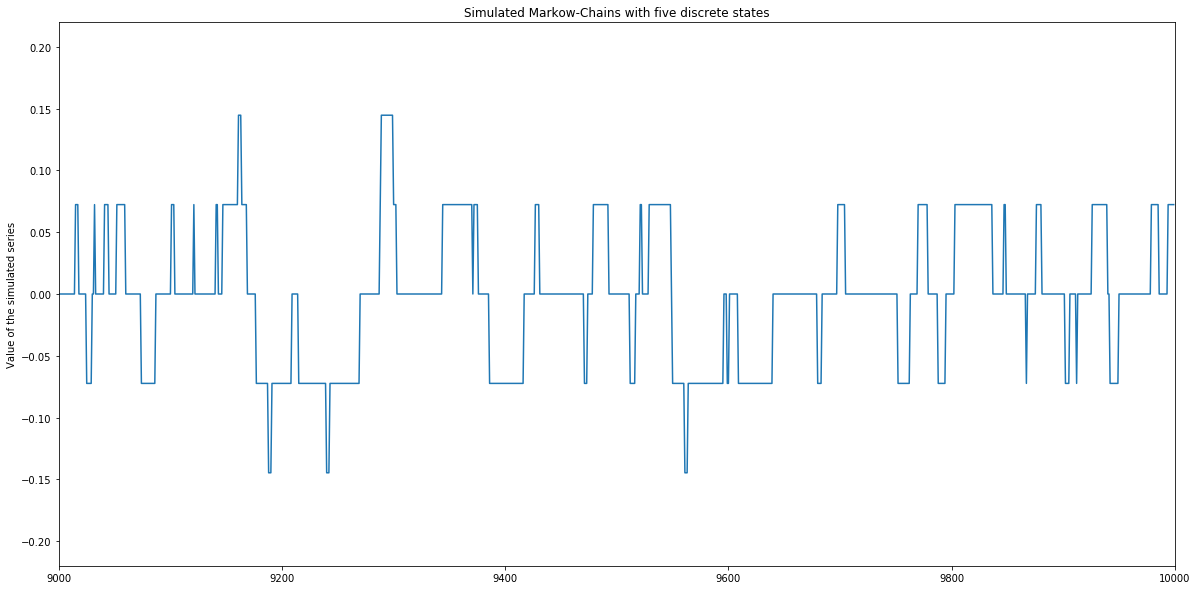

In [7]:
'Generate the states and the transition matrix with both Tauchen and Rouwenhorst'
Z1, Zprob1 = tauchen(N1,rho1,mu,sigmae1,m)

'Simulate serieses from the generated data'
sim1 = mcsim(Z1, Zprob1, N_sim,start, eps, mu, sigmae1)

'Plot the results'
plt.figure(figsize = (20,10))
plt.plot(sim1)
plt.title('Simulated Markow-Chains with five discrete states')
plt.ylabel('Value of the simulated series')
plt.axis([9000, 10000, -0.22, 0.22])
plt.show()

Besides Tauchen (1986) we now focus on the algorithm of Rouwenhorst (1995) for descretization.

In [8]:
def rouwen(rho, mu, sigma, num):
    
    '''
    Function Rouwen based on Rouwenhorst (1995)
    
    Purpose:    Construct transition probability matrix for discretizing an
                AR(1) y_t = rho y_(t-1) + eps_t process.
                
    Format:     {dscSp, transP} = rouwen(rho, mu, sigma, num)

    Inputs:
                rho: persistence (close to one)
                mu: mean and the middle point of the discrete state space]
                sigma: unconditional std.dev of the process y_t
                num: number of grid points on the discretized process

    Output:
                dscSp: discrete state space (num by 1 vector)
                transP: transition probability matrix over the grid
    '''

    dscSp = np.linspace(-(num-1)**(1/2)*sigma, (num-1)**(1/2)*sigma, num).T

    q = p = (rho + 1)/2.
    transP = np.array([[p**2, p*(1-q), (1-q)**2], \
                    [2*p*(1-p), p*q+(1-p)*(1-q), 2*q*(1-q)], \
                    [(1-p)**2, (1-p)*q, q**2]]).T

    while transP.shape[0] <= num - 1:

        len_P = transP.shape[0]
        transP = p*np.vstack((np.hstack((transP,np.zeros((len_P,1)))), np.zeros((1, len_P+1)))) \
        + (1-p)*np.vstack((np.hstack((np.zeros((len_P, 1)), transP)), np.zeros((1, len_P+1)))) \
        + (1-q)*np.vstack((np.zeros((1, len_P+1)), np.hstack((transP, np.zeros((len_P, 1)))))) \
        + q*np.vstack((np.zeros((1, len_P+1)), np.hstack((np.zeros((len_P, 1)), transP))))

        transP[1:-1] /= 2.

    if np.max(np.abs(np.sum(transP, axis=1) - np.ones(transP.shape))) >= 1e-12:
        print('Problem in rouwen routine!')
        return None
    else:
        return dscSp, transP

As before, we now generate the matrixes based on the algorithm, before simulating the series.

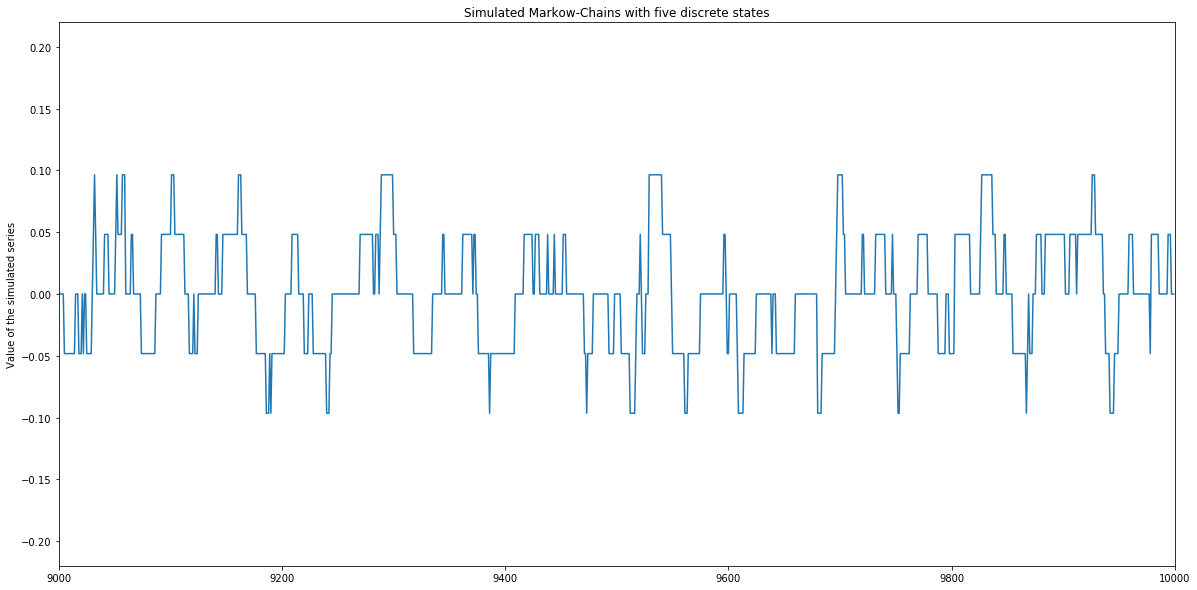

In [9]:
'Generate the states and the transition matrix with both Tauchen and Rouwenhorst'
Z2, Zprob2 = rouwen(rho1,mu,sigmay1,N1)

'Simulate serieses from the generated data'
sim2 = mcsim(Z2, Zprob2, N_sim,start, eps, mu, sigmae1)

'Plot the results'
plt.figure(figsize = (20,10))
plt.plot(sim2)
plt.title('Simulated Markow-Chains with five discrete states')
plt.ylabel('Value of the simulated series')
plt.axis([9000, 10000, -0.22, 0.22])
plt.show()

The next step is to compare the results obtained. 

Below we display the results of the simulations. The pictures, portray the original simulated series first, followed by the simulation based on the Tauchen result, and finally by the results generated by Rouwenhorst.

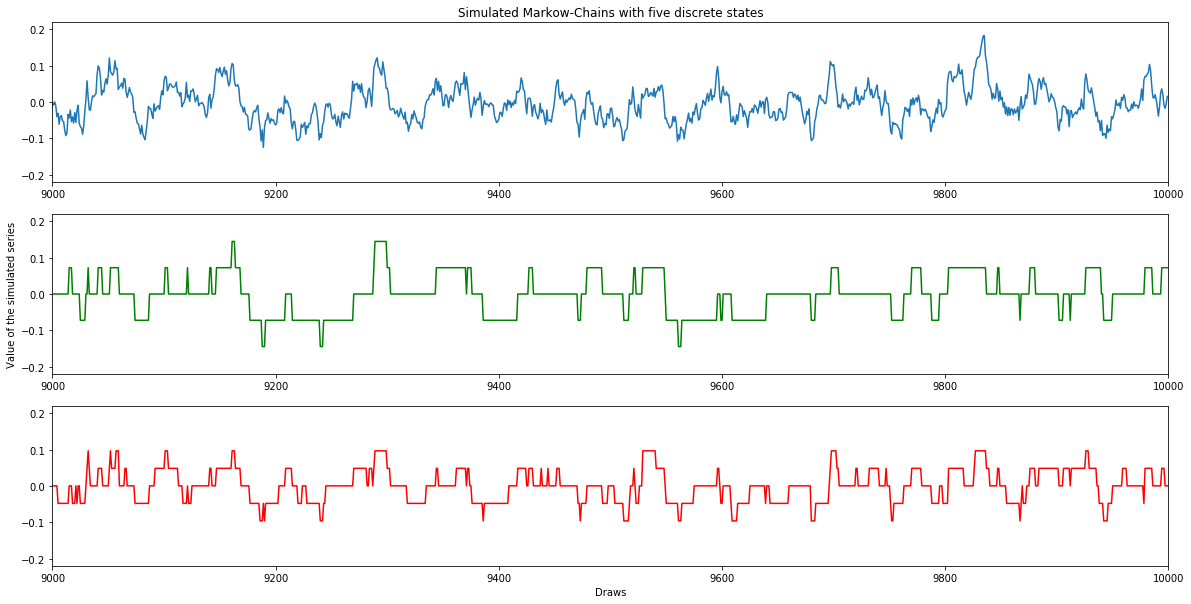

In [10]:
'Plot the results'
plt.figure(figsize = (20,10))
plt.subplot(311)
plt.plot(sim)
plt.title('Simulated Markow-Chains with five discrete states')
plt.axis([9000, 10000, -0.22, 0.22])
plt.subplot(312)
plt.plot(sim1, color = 'green')
plt.ylabel('Value of the simulated series')
plt.axis([9000, 10000, -0.22, 0.22])
plt.subplot(313)
plt.plot(sim2, color = 'red')
plt.xlabel('Draws')
plt.axis([9000, 10000, -0.22, 0.22])
plt.show()

From visual inspection, we find that the approximation with only five grid points does not replicate the original series as well as desired. While the simulations replicate some dynamics of the original series, the small number of states causes the simulation to stay longer in a single state, or to make big steps. Both lead to the result that the approximation fails to replicate the small steps the original series does. The Tauchen series makes bigger steps and consequently has a lower dynamic then the Rouwenhorst series, which seems to be a better approximation.

Figure 2 portrays the simulated series with 9 grid points. The increase to 9 grid points results in better approximations with both methods, although a slight difference is still existent. Looking at Figure 4, however, the Rouwenhorst approximation seems to replicate the dynamics of the original series a little bit better than Tauchen.

C:\Users\User\Anaconda3\envs\All languages\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
C:\Users\User\Anaconda3\envs\All languages\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead


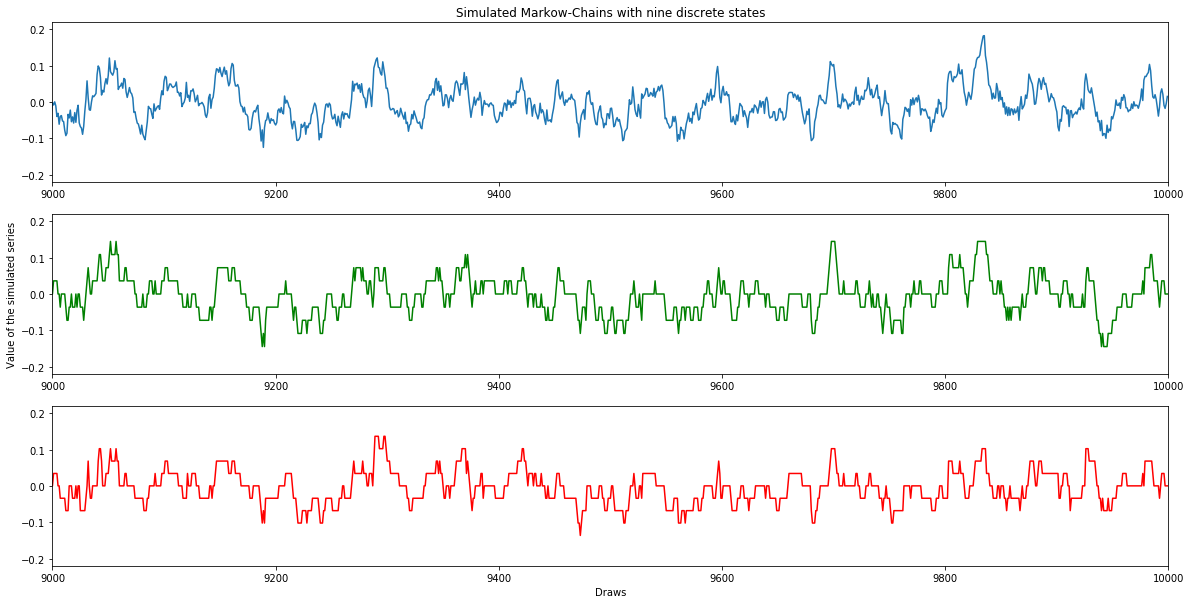

In [11]:
'Change the number of the discrete states'
N2 = 9
start = 5

'Generate the states and the transition matrix with both Tauchen and Rouwenhorst'
[Z3, Zprob3] = tauchen(N2,rho1,mu,sigmae1,m)
[Z4, Zprob4] = rouwen(rho1,mu,sigmay1,N2)


'Simulate serieses from the generated data'
sim3 = mcsim(Z3, Zprob3, N_sim,start, eps, mu, sigmae1)
sim4 = mcsim(Z4, Zprob4, N_sim,start, eps, mu, sigmae1)


'Plot the results'
plt.figure(figsize = (20,10))
plt.subplot(311)
plt.plot(sim)
plt.title('Simulated Markow-Chains with nine discrete states')
plt.axis([9000, 10000, -0.22, 0.22])
plt.subplot(312)
plt.plot(sim3, color = 'green')
plt.ylabel('Value of the simulated series')
plt.axis([9000, 10000, -0.22, 0.22])
plt.subplot(313)
plt.plot(sim4, color = 'red')
plt.xlabel('Draws')
plt.axis([9000, 10000, -0.22, 0.22])
plt.show()

Furthermore, we will compare the two approximation methods while using 15 discrete states.

C:\Users\User\Anaconda3\envs\All languages\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
C:\Users\User\Anaconda3\envs\All languages\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead


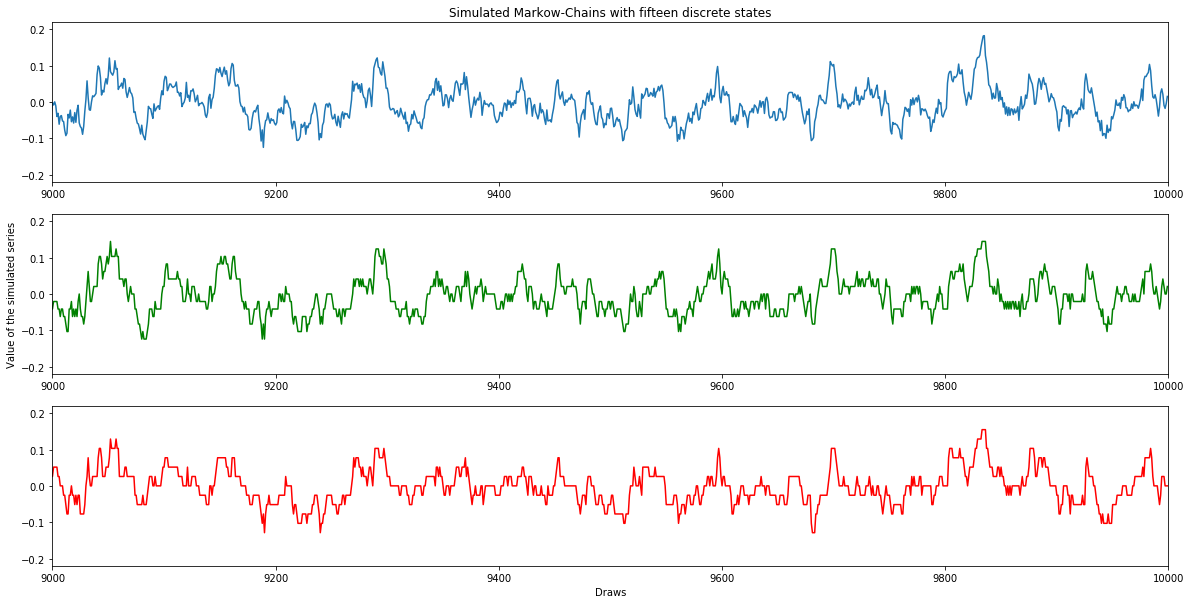

In [12]:
'Change the number of discrete states'
N3 = 15
start = 8

'Generate the states and the transition matrix with both Tauchen and Rouwenhorst'
[Z5, Zprob5] = tauchen(N3,rho1,mu,sigmae1,m)
[Z6, Zprob6] = rouwen(rho1,mu,sigmay1,N3)


'Simulate serieses from the generated data'
sim5 = mcsim(Z5, Zprob5, N_sim,start, eps, mu, sigmae1)
sim6 = mcsim(Z6, Zprob6, N_sim,start, eps, mu, sigmae1)


'Plot the results'
plt.figure(figsize = (20,10))
plt.subplot(311)
plt.plot(sim)
plt.title('Simulated Markow-Chains with fifteen discrete states')
plt.axis([9000, 10000, -0.22, 0.22])
plt.subplot(312)
plt.plot(sim5, color = 'green')
plt.ylabel('Value of the simulated series')
plt.axis([9000, 10000, -0.22, 0.22])
plt.subplot(313)
plt.plot(sim6, color = 'red')
plt.xlabel('Draws')
plt.axis([9000, 10000, -0.22, 0.22])
plt.show()

Figure 3 portrays the simuated series based on 15 grid points. The increase in grid points resulted again in a better approximation of the original series, whereas both approximations now mimic even small dynamics. Looking at Figure 4, the puzzling result emerges that the Tauchen approximation (green) seems to replicate the orginal series better than the Rouwenhorst approximation (red). The differences are small, but the Rouwenhorst series has some time periods where it is more distant from the original series. 


Now we turn to the statistical analysis. First we portray the inputs in our model and compare it with the simulated series. We see that the simulated series replicates the theoretical moments well and therefore is a suitable basis for our analysis. We will use these data for comparison with the moments generated from our approximations. The moments of the Tauchen approximation:


 No. of Grids | Mean | Sigma | Rho 
 :----: | :----: |  :----: | :----: 
 5     | 0.002250     | 0.060041    | 0.941974    
 9	   | 0.000803     | 0.055651    | 0.915431    
 15    | 0.002059     | 0.052576    | 0.918649    


And the moments for the Rouwenhorst approximation:

 
 No. of Grids | Mean | Sigma | Rho |
 :----: |  :----: | :----: | :----: |
 5  | 0.001052 | 0.047532 | 0.908644 |
 9  | 0.001446 | 0.048551 | 0.912883 |
 15 | 0.002326 | 0.049924 | 0.917522 |
 


From table 2 we can see that the approximations replicate important statistical moments in a satisfying manner. Already with only five grids, both methods lead to useable approximations, whereas the Rouwenhorst approximation is better than the Tauchen approximation. With increasing the number of grid points, this trend continues with the result that the Rouwenhorst approximation approximates the theoretical moments even better than the original series from which the Rouwenhorst coefficients are estimated from. This results impressively demonstrates the power of the method. On the other side does the Tauchen method replicate the simulated series, as well in a good way. As we increase the number of grid points, the quality of the approximation decreases. Both methods generate approximations with moments further away from the theoretical and the simulated series than the approximations with 9 grid points. Only the Tauchen method has a sigma, which is better than the sigma generated with nine grids. We therefore conclude, that increasing the number of grid points not necessarily results in a better approximation.

Last, we compare the generated series with their simulated original. As already mentioned above, with five grid points, the approximations of both series is relatively poor, whereas the Rouwenhorst seems to be more granular and is the better of the two approximations. With nine grid points, both methods result in good approximations, whereas the Tauchen method seems to follow the original process closer. As we learned from the statistical results, the Rouwenhorst method however replicates the moments of the original series better. Last, Tauchen replicates the series better with fifteen grid points than Rouwenhorst.

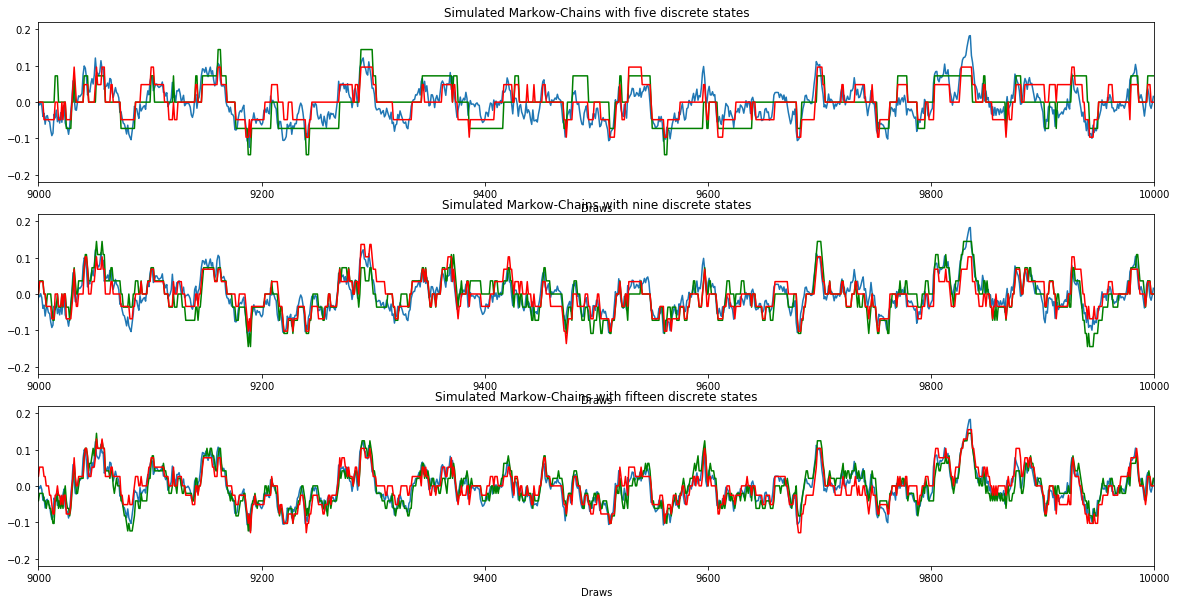

In [13]:
'Compute moments for the original and the simulated process'
E11 = sum(sim1) / N_sim
V11 = (np.var(sim1))**(1/2)
E12 = sum(sim2) / N_sim
V12 = (np.var(sim2))**(1/2)
rho11 = autocorr(sim1, t = 1)
rho12 = autocorr(sim2, t = 1)


E13 = sum(sim3) / N_sim
V13 = (np.var(sim3))**(1/2)
E14 = sum(sim4) / N_sim
V14 = (np.var(sim4))**(1/2)
rho13 = autocorr(sim3, t = 1)
rho14 = autocorr(sim4, t = 1)



E15 = sum(sim5) / N_sim
V15 = (np.var(sim5))**(1/2)
E16 = sum(sim6) / N_sim
V16 = (np.var(sim6))**(1/2)
rho15 = autocorr(sim5, t = 1)
rho16 = autocorr(sim6, t = 1)


'Plot the fit of the approximations with the original series'
plt.figure(figsize = (20,10))
plt.subplot(311)
plt.plot(sim)
plt.plot(sim1, color = 'green')
plt.plot(sim2, color = 'red')
plt.xlabel('Draws')
plt.axis([9000, 10000, -0.22, 0.22])
plt.title('Simulated Markow-Chains with five discrete states')

plt.subplot(312)
plt.plot(sim)
plt.plot(sim3, color = 'green')
plt.plot(sim4, color = 'red')
plt.xlabel('Draws')
plt.axis([9000, 10000, -0.22, 0.22])
plt.title('Simulated Markow-Chains with nine discrete states')

plt.subplot(313)
plt.plot(sim)
plt.plot(sim5, color = 'green')
plt.plot(sim6, color = 'red')
plt.xlabel('Draws')
plt.axis([9000, 10000, -0.22, 0.22])
plt.title('Simulated Markow-Chains with fifteen discrete states')


'MSE analysis:'

mse1 = np.var(sim - sim1)
mse2 = np.var(sim - sim2)
mse3 = np.var(sim - sim3)
mse4 = np.var(sim - sim4)
mse5 = np.var(sim - sim5)
mse6 = np.var(sim - sim6)


The subjective impression, that Tauchen follows the series better with nine grid points is supported by a mean-squared-error-analysis of the difference between the original series and its approximations. Although the difference is small, Tauchen replicates the original series better with nine and fifteen grid points. Additionally Rouwenhorst performs better with lower numbers of grids.

\begin{table*}[htb]
\centering
\ra{1.3}
\begin{tabular}{@{}ccc@{}}
\toprule
No. of Grids & Tauchen & Rouwenhorst \\
\midrule
5 	&	0.002550 &	0.001514 \\
9	&	0.001034 &	0.001049 \\
15	&	0.000630 &	0.000746 \\
\bottomrule
\end{tabular}
\caption{MSE analysis of the series}
\end{table*}

Changing $\rho$ to 0.99 (not reported), we find that the results hold for more persistent shocks, as well. While Rouwenhorst replicates the series with respect to the statistical moments and the MSE better than Tauchen with nine and with five grid points, Tauchen is better with fifteen grid points. Interestingly, both series have problems with the replication of the dynamics of the series and have much higher MSE than with lower persistence.

### Using Quantecon packages

While this was a worthwhile exercise, we want to explore the already existing codes for generating descretized series. Quantecon provides some useful applications for that.